In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project-2-2-vgg16-unet-epoch-100/best_weight.h5
/kaggle/input/project-2-2-vgg16-unet-epoch-100/__results__.html
/kaggle/input/project-2-2-vgg16-unet-epoch-100/vgg16_unet_epoch_100.h5
/kaggle/input/project-2-2-vgg16-unet-epoch-100/__notebook__.ipynb
/kaggle/input/project-2-2-vgg16-unet-epoch-100/__output__.json
/kaggle/input/project-2-2-vgg16-unet-epoch-100/custom.css
/kaggle/input/project-2-2-vgg16-unet-epoch-100/vgg16_unet_epoch_100/fingerprint.pb
/kaggle/input/project-2-2-vgg16-unet-epoch-100/vgg16_unet_epoch_100/saved_model.pb
/kaggle/input/project-2-2-vgg16-unet-epoch-100/vgg16_unet_epoch_100/keras_metadata.pb
/kaggle/input/project-2-2-vgg16-unet-epoch-100/vgg16_unet_epoch_100/variables/variables.index
/kaggle/input/project-2-2-vgg16-unet-epoch-100/vgg16_unet_epoch_100/variables/variables.data-00000-of-00001
/kaggle/input/project-2-2-vgg16-unet-epoch-100/__results___files/__results___10_0.png
/kaggle/input/project-2-2-vgg16-unet-epoch-100/__results___files/__results__

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
!pip install keras-unet-collection
import keras_unet_collection
from keras_unet_collection import models
from keras_unet_collection.losses import dice_coef, iou_seg, dice
from PIL import Image
import ipywidgets as widgets

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.2 MB/s eta 0:00:00


In [3]:
"""Setting Some Parameters"""
#Setting values of HU
HU_MIN = -1000
HU_MAX = 3000

SLICE_X = False
SLICE_Y = False
SLICE_Z = True
SLICE_DECIMATE_IDENTIFIER = 3

#Defining Constants
SEED = 42
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

#train path
train_dir = "/kaggle/input/project-1-saving-slices/train/"
train_img_dir = os.path.join(train_dir, 'img')
train_mask_dir = os.path.join(train_dir, 'mask')

#valid path
valid_dir = "/kaggle/input/project-1-saving-slices/valid/"
valid_img_dir = os.path.join(valid_dir, 'img')
valid_mask_dir = os.path.join(valid_dir, 'mask')

#test path
test_dir = "/kaggle/input/project-1-saving-slices/test/"
test_img_dir = os.path.join(test_dir, 'img')
#test_mask_dir = os.path.join(test_dir, 'mask')

In [4]:
def normalize_img_intensity_range(img):
  img[img < HU_MIN] = HU_MIN
  img[img > HU_MAX] = HU_MAX
  return (img - HU_MIN) / (HU_MAX - HU_MIN)

In [5]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dc_loss = dice_loss(y_true, y_pred)
    return bce_loss + dc_loss
# Load the model with custom objects
#with tf.keras.utils.custom_object_scope():
model = tf.keras.models.load_model('/kaggle/input/project-2-2-vgg16-unet-epoch-100/vgg16_unet_epoch_100.h5',
                                  custom_objects={'dice':dice,'dice_coef': dice_coef, 'iou_seg':iou_seg, 'combined_loss':combined_loss})

In [6]:
targetName = 'colon_005'
targetImagePath = f'/kaggle/input/satyajeet-extracting-data-formating/train_img/{targetName}.nii.gz'
targetMaskPath  = f'/kaggle/input/satyajeet-extracting-data-formating/train_mask/{targetName}.nii.gz'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalize_img_intensity_range(imgTargetNii.get_fdata())
imgMask = imgMaskNii.get_fdata()

In [7]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height))

In [8]:
# Import the required modules
import nibabel as nib
from ipywidgets import interact
from matplotlib import pyplot as plt
# Visualize Images as a slider
def show_slice(i):
    plt.imshow(imgTarget[:,:,i], cmap='gray')
    plt.show()

interact(show_slice, i=(0, imgTarget.shape[2]-1))

interactive(children=(IntSlider(value=48, description='i', max=97), Output()), _dom_classes=('widget-interact'…

<function __main__.show_slice(i)>

In [9]:
# Import the required modules
import nibabel as nib
from ipywidgets import interact
from matplotlib import pyplot as plt
# Visualize Images as a slider
def show_slice(i):
    plt.imshow(imgMask[:,:,i], cmap='gray')
    plt.show()

interact(show_slice, i=(0, imgMask.shape[2]-1))

interactive(children=(IntSlider(value=48, description='i', max=97), Output()), _dom_classes=('widget-interact'…

<function __main__.show_slice(i)>

In [10]:
sliceIndex = 56

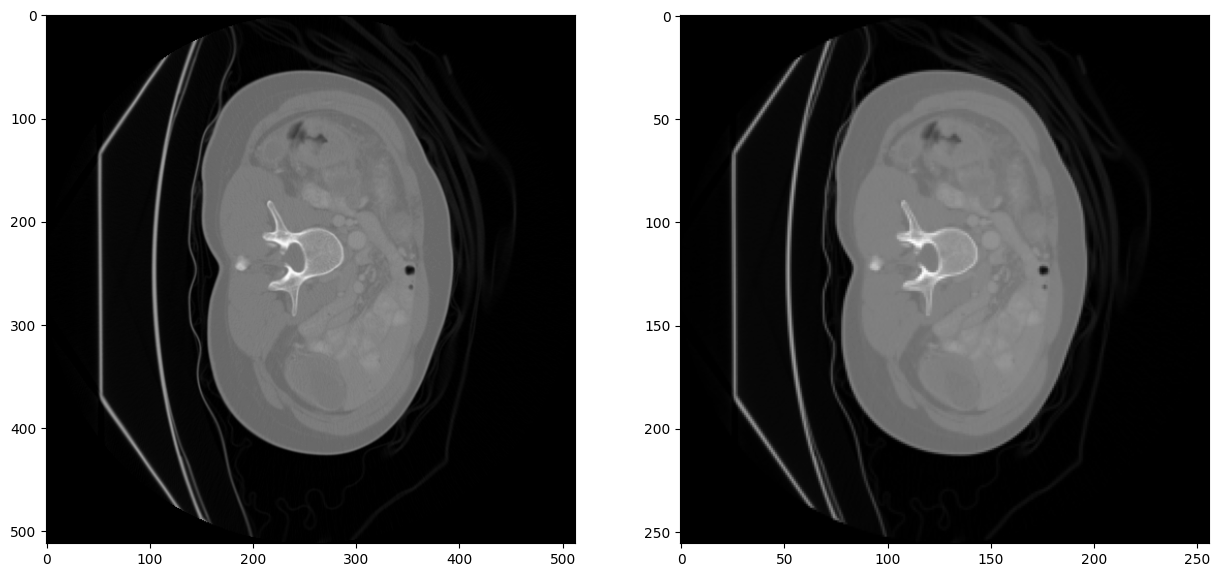

((512, 512), (256, 256))

In [11]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[:,:,sliceIndex]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

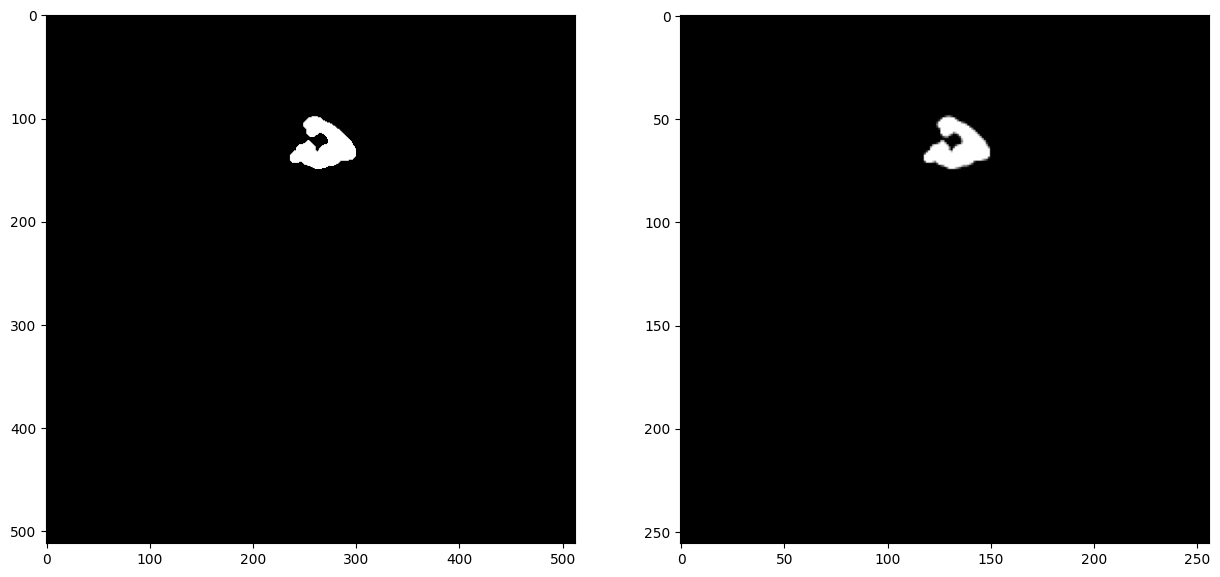

((512, 512), (256, 256))

In [12]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[:,:,sliceIndex]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

1/1 [==============================] - 13s 13s/step


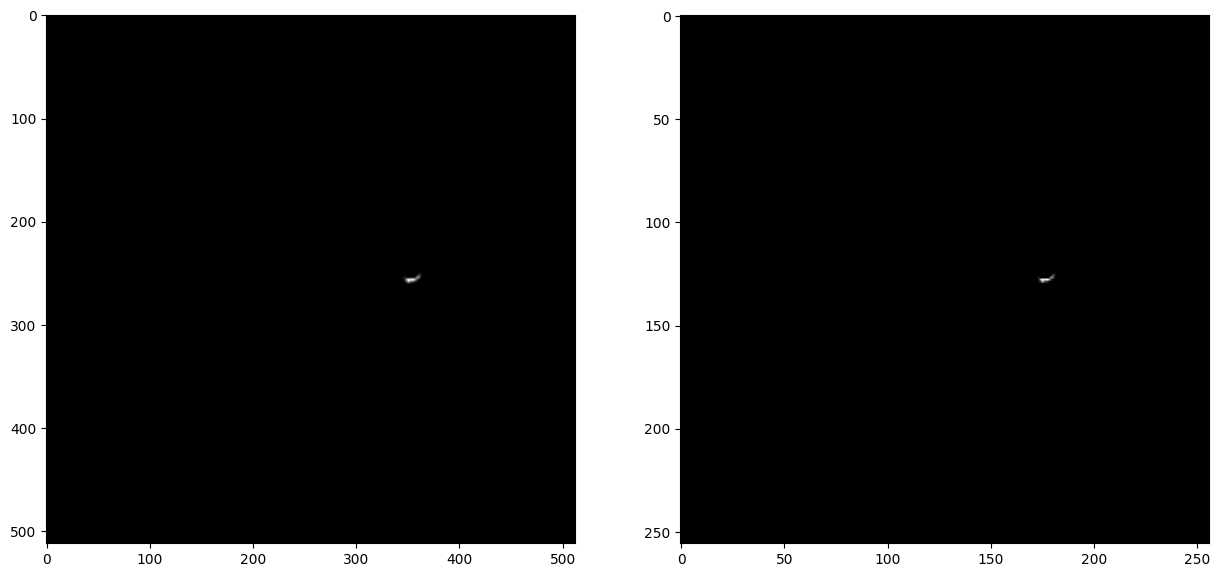

((512, 512), (256, 256))

In [13]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
#maskPredict[maskPredict>0.5] = 1.0
#maskPredict[maskPredict<=0.5] = 0.0
#maskPredictScaled[maskPredictScaled>0.5] = 1.0
#maskPredictScaled[maskPredictScaled<=0.5] = 0.0
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

In [14]:
#https://brainbrowser.cbrain.mcgill.ca/volume-viewer

In [15]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [16]:
predImg = predictVolume(imgTarget)

1/1 [==============================] - 0s 21ms/step


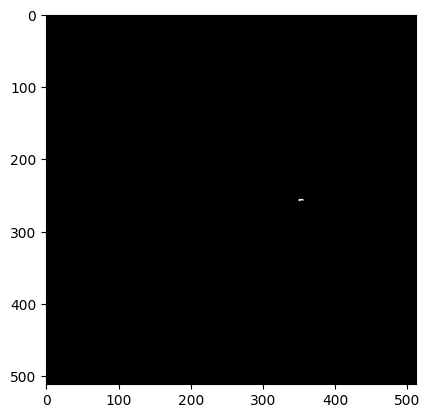

In [17]:
plt.imshow(predImg[:,:,sliceIndex], cmap='gray')

In [18]:
# Import the required modules
import nibabel as nib
from ipywidgets import interact
from matplotlib import pyplot as plt
# Visualize Images as a slider
def show_slice(i):
    plt.imshow(predImg[:,:,i])
    plt.show()

interact(show_slice, i=(0, predImg.shape[2]-1))

interactive(children=(IntSlider(value=48, description='i', max=97), Output()), _dom_classes=('widget-interact'…

<function __main__.show_slice(i)>

In [19]:
def show_selected_images(slice_number):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(imgTarget[:,:,slice_number], cmap='gray')
    axs[0].set_title("Input Image")

    axs[1].imshow(imgMask[:,:,slice_number], cmap='gray')
    axs[1].set_title("Ground Truth")

    axs[2].imshow(predImg[:,:,slice_number], cmap='gray')
    axs[2].set_title("Predicted Mask")

    plt.show()

slice_slider = widgets.IntSlider(
    min=0,
    max=imgTarget.shape[2]-1,
    value=0,
    description='Slice Number:'
)

interact(show_selected_images, slice_number=slice_slider)

interactive(children=(IntSlider(value=0, description='Slice Number:', max=97), Output()), _dom_classes=('widge…

<function __main__.show_selected_images(slice_number)>

In [20]:
import time

# Load model and input data (adjust as per your specific code)
#model = load_model()
#input_data = prepare_input_data()

# Warm-up the GPU (optional, to ensure GPU is fully utilized)
warmup_iterations = 10
for _ in range(warmup_iterations):
    _ = model.predict(imageInput,verbose=0)[0,:,:,0]

# Measure inference time
num_iterations = 100  # Adjust based on your requirements
total_time = 0
for _ in range(num_iterations):
    start_time = time.time()
    _ = model.predict(imageInput,verbose=0)[0,:,:,0]
    end_time = time.time()
    total_time += (end_time - start_time)

average_inference_time = total_time / num_iterations
print(f"Average Inference Time: {average_inference_time*1000:.4f} milli-seconds")

Average Inference Time: 85.7653 milli-seconds
